In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [3]:
df = pd.read_csv('data/1_mw_disp_full.csv')

In [4]:
df.columns = ['x', 'y', 'z']
df['t_ns'] = np.arange(df.shape[0])*0.1/1000

In [5]:

def plot_sample(ax, fig, df, frac=0.01, color='t_ns'):
    df_sample = df.sample(frac=frac)
    c = ax.scatter(xs=df_sample.x, ys = df_sample.y, zs = df_sample.z, c=df_sample[color])
    fig.colorbar(c)
    return ax, fig

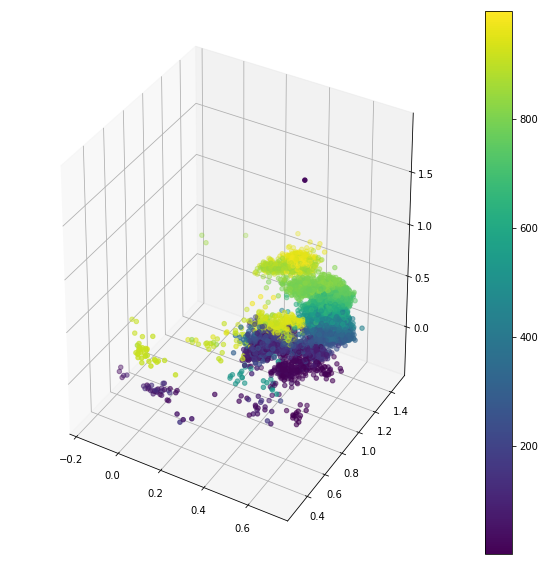

In [6]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plot_sample(ax, fig, df, frac=0.001)
plt.show()


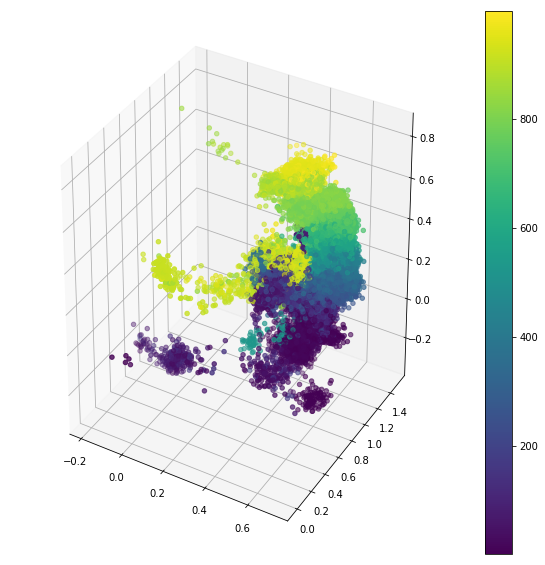

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plot_sample(ax, fig, df, frac=0.005)
plt.show()

The more points you use the less discrete the trajectory becomes.  

To gauge how discrete the interstices are we can do three things. 
1. Plot the histogram of distances traveled - we would expect to see a large proportion of small distances (0.2 nm) and a small proportion of larger hops (1nm).  This would depened on time difference used however.  At small distances you would only see small hops. At large time differences, the distribution would depend on the residence time in each basin.  If there were no basins you would see a small range of distances. 
2. Do hierachical clustering, again at different time differences. 
3. Plot the rmsd as a function of time. 

In [7]:
xyz = df.values

## RMSD vs time

In [8]:
# dt = 1 # required timestep
# dts = 100/1000/1000 # timestep in ns
# dn = int(dt/dts)
rmsd = np.sqrt(np.sum((xyz[:,:3]-xyz[0,:3])**2, axis=1))

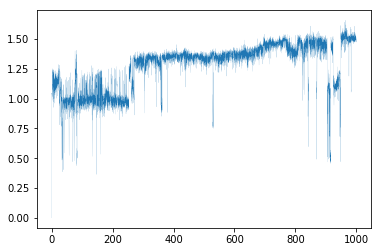

In [9]:
plt.plot(xyz[::1000,3], rmsd[::1000], lw=.1)
plt.show()

## Distribution of distances

In [27]:
def get_distances(xyz, dt=1):
    dt = 1 # required timestep
    dts = 100/1000/1000 # timestep in ns
    dn = int(dt/dts)
    dxyz = xyz[dn:, :3] - xyz[:-dn, :3]
    rmsd_dt = np.sqrt(np.sum((dxyz)**2, axis=1))
    return rmsd_dt

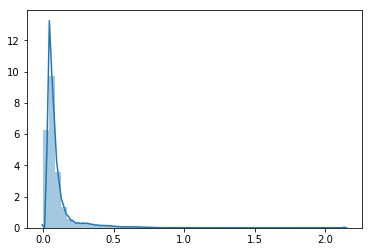

In [28]:
fig, axes = plt.subplots()
sns.distplot(get_distances(xyz, dt=1))


## Hierachical clustering

In [12]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import time

Hierachical clustering is O(n^2), we have 10^7 points so we should first calculate the time it's going to take. 

In [13]:
times = []
dns = [5000, 1000, 500]
for dn in dns:
    tic = time.time()
    Z = linkage(xyz[::dn,:2], method='ward', metric='euclidean', optimal_ordering=False)
    toc = time.time()
    print(dn)
    times.append(toc-tic)

5000
1000
500


In [14]:
n_obs = xyz.shape[0]/np.array(dns)

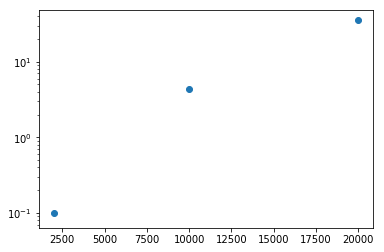

In [15]:
plt.scatter(n_obs, times)
plt.yscale('log')

In [16]:
import statsmodels.api as sm
model = sm.OLS(np.log(times), n_obs).fit()
model.summary()

/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     3.748
Date:                Thu, 07 Feb 2019   Prob (F-statistic):              0.193
Time:                        10:10:41   Log-Likelihood:                -5.5344
No. Observations:                   3   AIC:                             13.07
Df Residuals:                       2   BIC:                             12.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002   8.35e-05      1.936      0.193      -0.000       0.001
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.913
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.485
Skew:                          -0.639   Prob(JB):                        0.785
Kurtosis:                       1.500   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

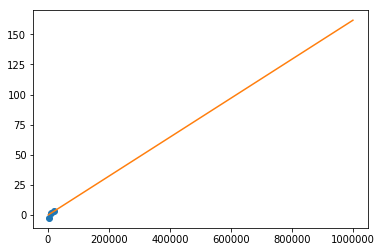

In [17]:
plt.plot(n_obs, model.predict(n_obs))
plt.scatter(n_obs, np.log(times))
new_obs = xyz.shape[0]/np.array(list(dns)+[100, 10])
plt.plot(new_obs, model.predict(new_obs))


In [18]:
np.exp(model.predict(new_obs))/60

array([  2.30295752e-02,   8.39526932e-02,   4.22883282e-01,
         1.75269998e+05,   2.75700189e+68])

So for using 1% of the data, it should take 20000 minutes, and for 10% it will take longer than the age of the universe.  Not viable. 

In [19]:
df_sample = df.iloc[::1000, 0:3]

In [20]:
Z = linkage(df_sample.values, method='ward', metric='euclidean', optimal_ordering=False)


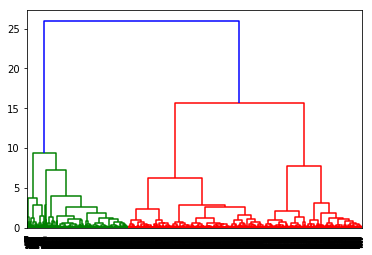

In [21]:
_ = dendrogram(Z)

In [22]:
labels = fcluster(Z, t=20, criterion='distance')

In [23]:
df_sample['labels'] = labels

In [24]:
df_sample.head()

,x,y,z,labels
0,-0.02841,0.00079,-0.01119,1
1000,0.59640,0.80962,-0.23694,1
2000,0.53931,0.80161,-0.24756,1
3000,0.56509,0.76642,-0.24926,1
4000,0.60690,0.77184,-0.27991,1


(<matplotlib.axes._subplots.Axes3DSubplot at 0x1a17225588>,
 <matplotlib.figure.Figure at 0x1a17225b00>)

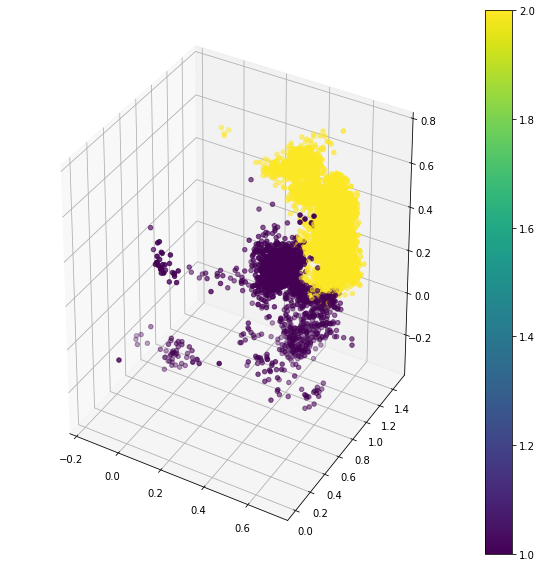

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plot_sample(ax, fig, df_sample, frac=1, color='labels')